In [1]:
import numpy as np
import re
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
import matplotlib.cm as mcm
import matplotlib.colors as mcol
import scipy.stats as sts
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mutual_info_score
import numpy.ma as nma
from sklearn import linear_model
#import fitsio
from data_get import *
from make_rgb import *

plt.rcParams['figure.figsize'] = [8., 8.]
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.fontset"] = 'cm'

In [2]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(np.shape(sources))

morph_all = np.load('morph_array.npy')
print(np.shape(morph_all))

sersic_all = np.load('sersic_array.npy')
print(np.shape(sersic_all))

(6337, 26)


FileNotFoundError: [Errno 2] No such file or directory: 'morph_array.npy'

In [3]:
rd2deg = (180*3600)/np.pi

mst = sources['logM'].iloc[morph_all[:,0,0]]
zspec = sources['zspec'].iloc[morph_all[:,0,0]]
res = 1e6*(0.262*cosmo.comoving_distance(zspec).value)/rd2deg

npr = {1:[[0.3,1.0],r'${\it Gini}$'],2:[[-2,-0.5],r'$M_{20}$'],5:[[1.5,4],r'$Concentration$'],6:[[-0.75,0.75],r'$Asymmetry$'],7:[[-0.1,0.1],r'$Smoothness$']}

def merger_line(M20): return -0.14*M20 + 0.33
def hubble_line(M20): return  0.14*M20 + 0.80
def SGM(G,M20): return 0.139*M20 + 0.99*G - 0.327

In [4]:
channels = {'g':mcm.cividis,'r':mcm.viridis,'i':mcm.inferno,'z':mcm.Greys_r}
griz_col = ['tab:blue','tab:green','tab:orange','tab:red']
positions = [0, 1, 2, 3]

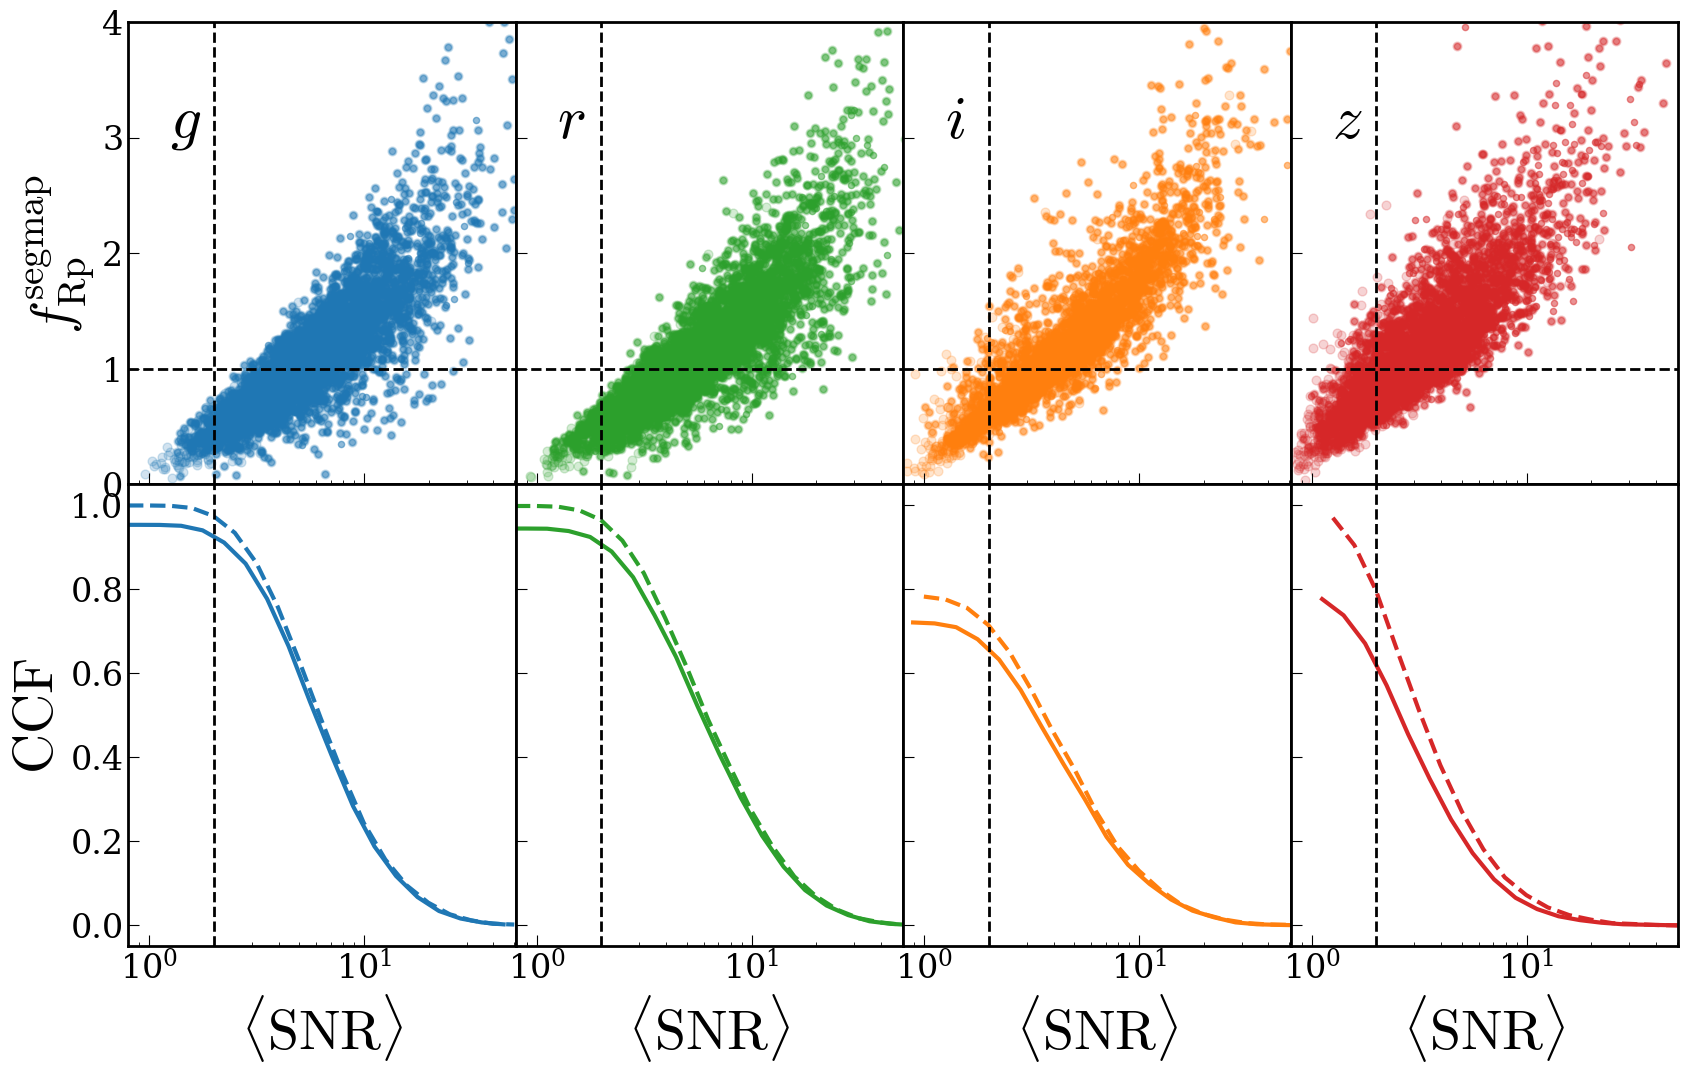

In [5]:
#high_snr = np.where((morph_all[:,0,10]>1)&(morph_all[:,1,10]>1))[0]
#print(len(high_snr))
fig,ax=plt.subplots(2,4,figsize=(20,12),sharey='row',sharex='col')

ls_fg = ['-','--']
snr_bins = np.logspace(np.log10(0.5),np.log10(50),21)

for i,k in enumerate(channels):
    flag1 = np.where(morph_all[:,i,9]==0)[0]
    flag2 = np.where(morph_all[:,i,9]<=1)[0]

    ax[0,i].scatter(morph_all[~flag1,i,10],morph_all[~flag1,i,11],alpha=0.2,c=griz_col[i],s=40)
    ax[0,i].scatter(morph_all[flag1,i,10],morph_all[flag1,i,11],alpha=0.5,c=griz_col[i],s=20)

    
    for l,fg in enumerate([flag1,flag2]):
        bin_sat, bin_edg = np.histogram(morph_all[~fg,i,10],bins=snr_bins)
        bin_edg*=np.sqrt(bin_edg[1]/bin_edg[0])
        bin_sat=np.cumsum(bin_sat[::-1])[::-1]/len(morph_all[:,i,10])
        ax[1,i].plot(bin_edg[:-1],bin_sat,c=griz_col[i],lw=3,ls=ls_fg[l])


    ax[0,i].axhline(1.0,lw=2,ls='--',color='black',zorder=101)
    #ax[0,i].axvline(5.0,lw=2,ls='-.',color='black',zorder=101)
    #ax[1,i].axvline(5.0,lw=2,ls='-.',color='black',zorder=101)

    ax[0,i].axvline(2.0,lw=2,ls='--',color='black',zorder=101)
    ax[1,i].axvline(2.0,lw=2,ls='--',color='black',zorder=101)


    ax[0,i].text(1.25,3,r'${\it '+k+'}$',fontsize=44)
    ax[0,i].set_xscale('log')
    ax[0,i].set_xlim((0.8,50.8))
    ax[0,i].set_ylim((0,4))
    ax[1,i].set_xlabel(r'$\langle SNR \rangle$',fontsize=40)
ax[0,0].set_ylabel( r'${\it f}^{segmap}_{Rp}$',fontsize=40)
ax[1,0].set_ylabel( r'$CCF$',fontsize=40)
        

#ax.scatter(rmag,sfbr,alpha=0.4,s=60,c='none',edgecolor='black')

plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.savefig('SNRdistributions.pdf',bbox_inches='tight')


/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continu

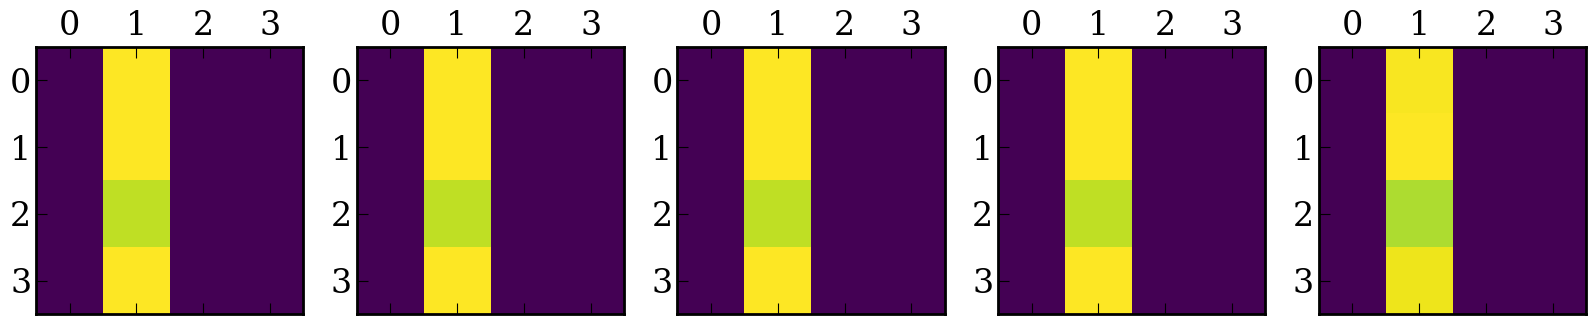

g 4544
r 4435
i 3170
z 3228


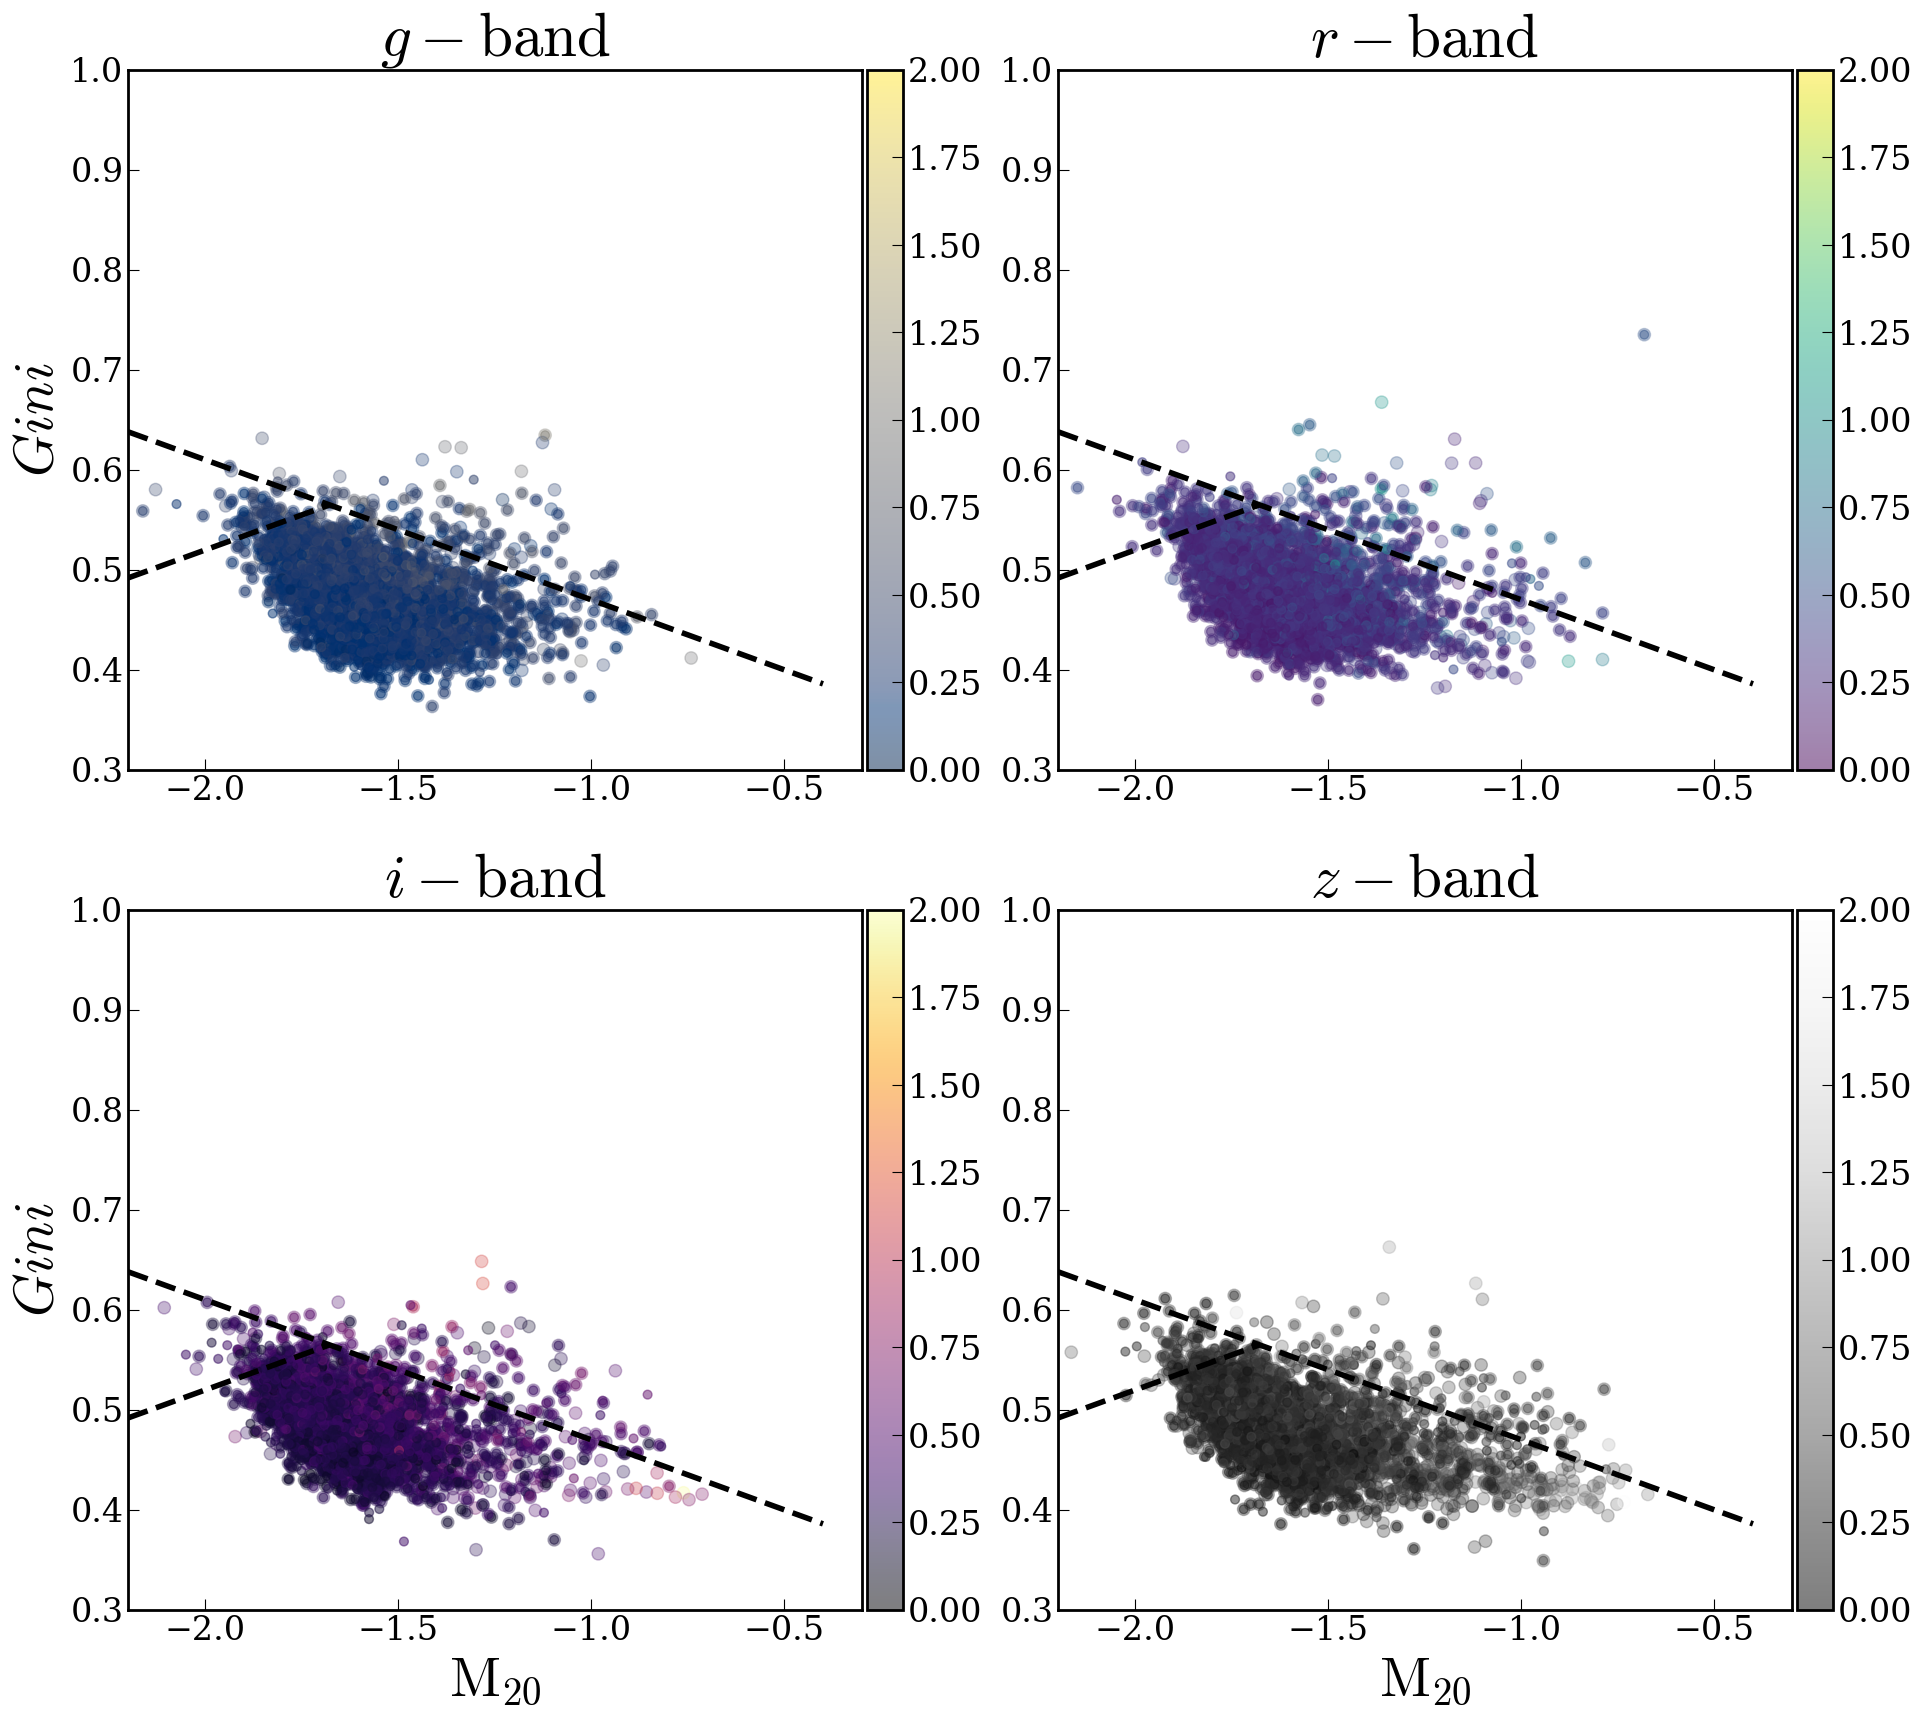

In [6]:
fig,ax=plt.subplots(2,2,figsize=(22,20))

M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)


for i,k in enumerate(channels):

    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    print(k,len(selc))
    
    ax[i//2,i%2].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    ax[i//2,i%2].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax[i//2,i%2].scatter(morph_all[~selc,i,2],morph_all[~selc,i,1],c=morph_all[~selc,i,8],s=80,cmap=channels[k],vmin=0,vmax=2,alpha=0.3)
    im = ax[i//2,i%2].scatter(morph_all[selc,i,2],morph_all[selc,i,1],c=morph_all[selc,i,8],s=40,cmap=channels[k],vmin=0,vmax=2,alpha=0.5)


    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    ax[i//2,i%2].set_ylim((0.3,1.0))
    ax[i//2,i%2].set_xlim((-2.2,-0.3))
    ax[i//2,i%2].set_rasterized(True)

for j in range(2):
    ax[j,0].set_ylabel( r'${\it Gini}$',fontsize=40)
    ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)
    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=channels[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

g 3476
r 3433
i 2434
z 2565


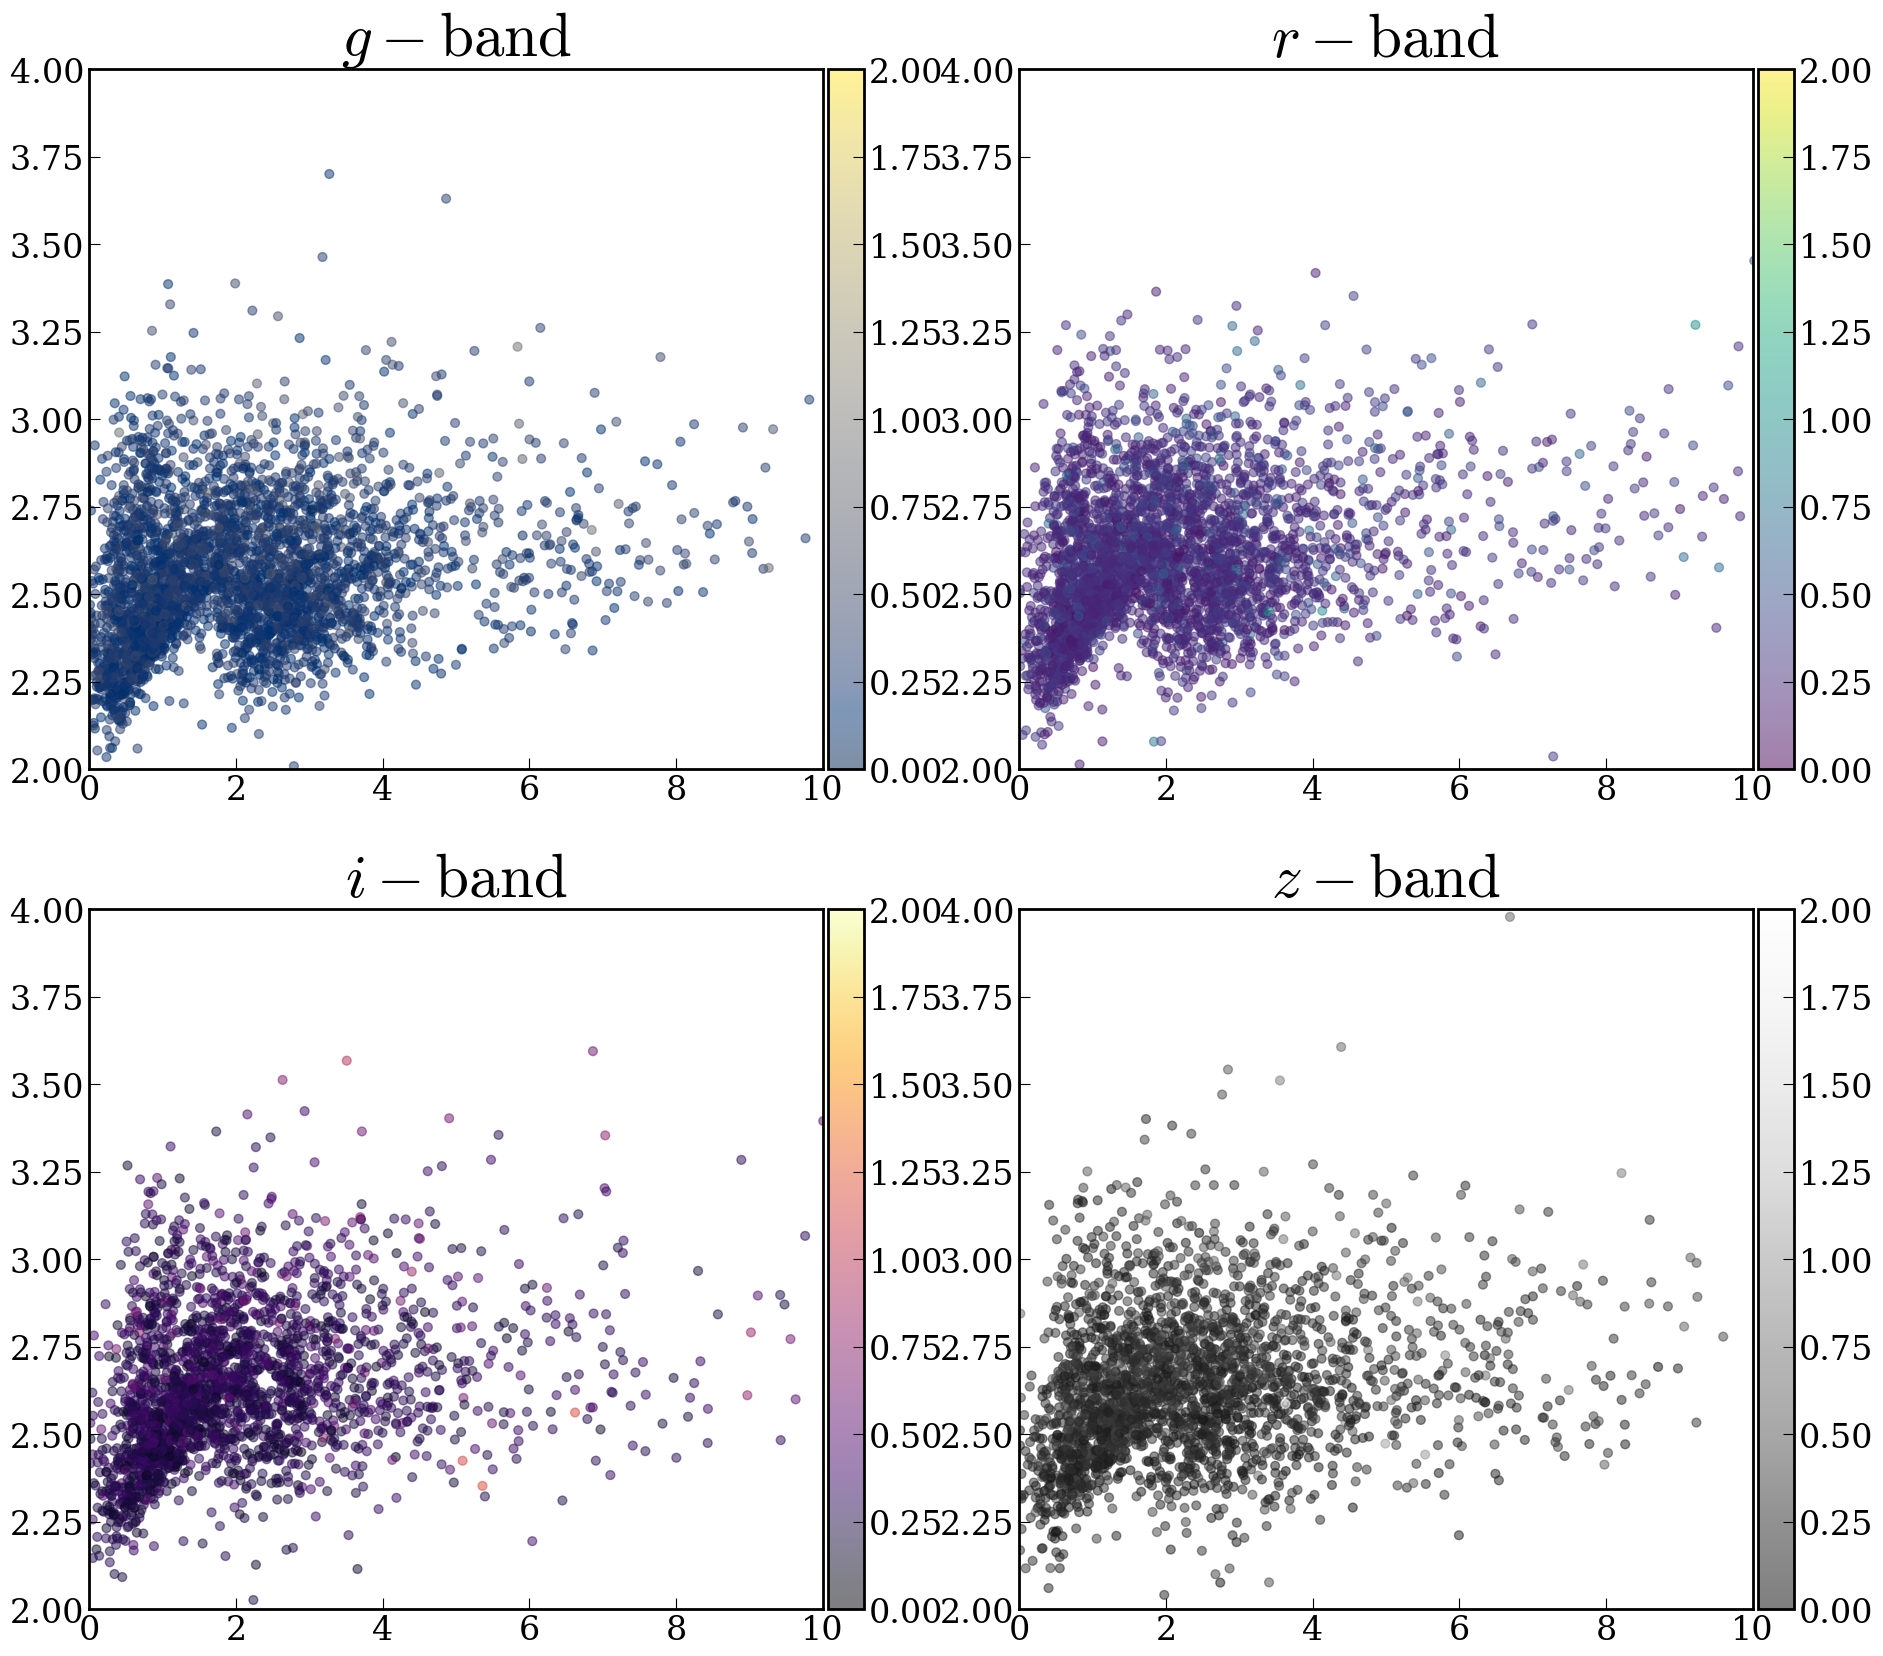

In [17]:
fig,ax=plt.subplots(2,2,figsize=(22,20))

M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)


for i,k in enumerate(channels):
    selc = np.where((sersic_all[:,i,3]==0)&(morph_all[:,i,10]>=2))[0]
    if i==2: selc = np.where((sersic_all[:,i,3]==0)&(morph_all[:,i,10]>=2)&(~np.isnan(sources['m_i0'].iloc[morph_all[:,i,0]])))[0]
    print(k,len(selc))
    
    #ax[i//2,i%2].scatter(sersic_all[~selc,i,0],morph_all[~selc,i,5],c=morph_all[~selc,i,8],s=80,cmap=channels[k],vmin=0,vmax=2,alpha=0.3)
    im = ax[i//2,i%2].scatter(sersic_all[selc,i,0],morph_all[selc,i,5],c=morph_all[selc,i,8],s=40,cmap=channels[k],vmin=0,vmax=2,alpha=0.5)


    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    ax[i//2,i%2].set_ylim((2.0,4.0))
    ax[i//2,i%2].set_xlim((0.0,10.0))
    ax[i//2,i%2].set_rasterized(True)

#for j in range(2):
    #ax[j,0].set_ylabel( r'${\it Gini}$',fontsize=40)
    #ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)
    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=channels[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

g 4544
r 4435
i 3170
z 3228


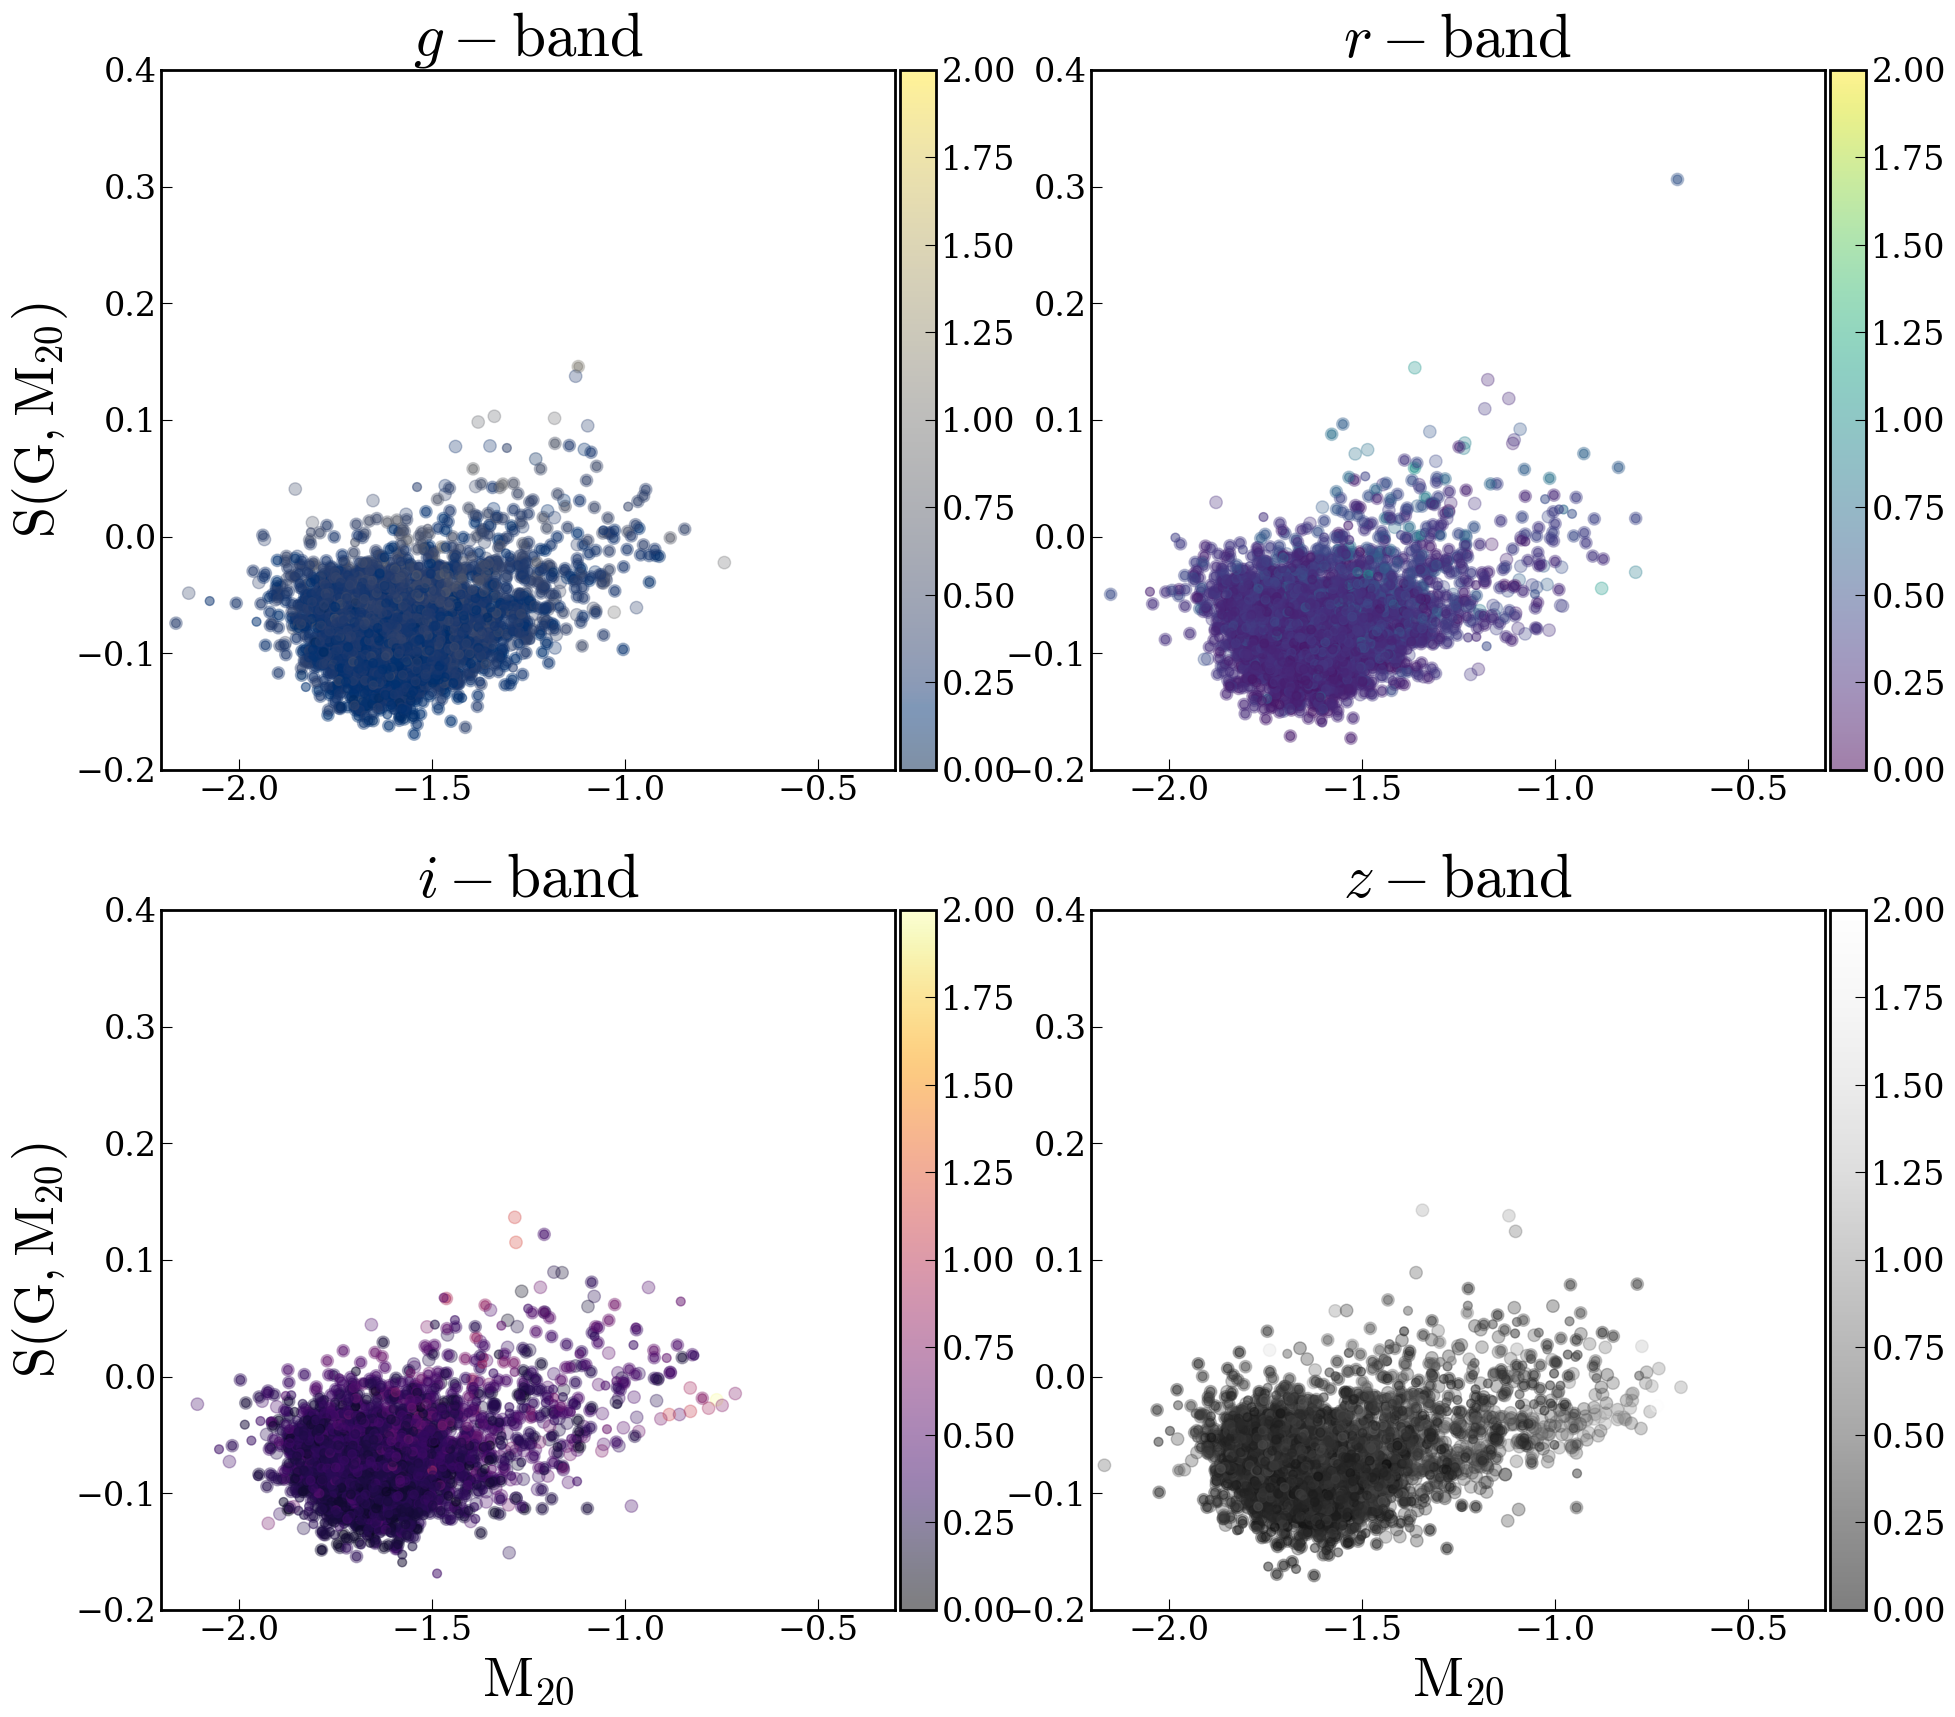

In [7]:

fig,ax=plt.subplots(2,2,figsize=(22,20))

M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)


for i,k in enumerate(channels):

    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    print(k,len(selc))
    
    ax[i//2,i%2].scatter(morph_all[~selc,i,2],SGM(morph_all[~selc,i,1],morph_all[~selc,i,2]),c=morph_all[~selc,i,8],s=80,cmap=channels[k],vmin=0,vmax=2,alpha=0.3)
    im = ax[i//2,i%2].scatter(morph_all[selc,i,2],SGM(morph_all[selc,i,1],morph_all[selc,i,2]),c=morph_all[selc,i,8],s=40,cmap=channels[k],vmin=0,vmax=2,alpha=0.5)


    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    ax[i//2,i%2].set_ylim((-0.2,0.4))
    ax[i//2,i%2].set_xlim((-2.2,-0.3))
    ax[i//2,i%2].set_rasterized(True)

for j in range(2):
    ax[j,0].set_ylabel( r'$S(G,M_{20})$',fontsize=40)
    ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)



    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=channels[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

In [127]:
from sklearn.neighbors import KernelDensity

def hess_arr(x_val,y_val,hdex,nbins):
    x_val = (x_val - hdex[0])/(hdex[1]-hdex[0])
    y_val = (y_val - hdex[2])/(hdex[3]-hdex[2])
    dz=1.0/nbins
    
    
    xx,yy=np.meshgrid(np.arange(dz,1+dz,dz),np.arange(dz,1+2*dz,dz))
    xy_sample = np.vstack([yy[:-1].ravel(), xx[:-1].ravel()]).T
    xy_train  = np.vstack([y_val,x_val]).T

    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.08)
    kde_skl.fit(xy_train)
    hss_est = np.exp(np.reshape(kde_skl.score_samples(xy_sample),(nbins,nbins)))
    #hss_est = hss_est/((hdex[3] - hdex[2])*(hdex[1] - hdex[0]))
    hss_est = hss_est/np.sum(hss_est)
    #hss_est = hss_est/np.amax(hss_est)
    #print(dz*dz*np.sum(hss_est))

    return hss_est

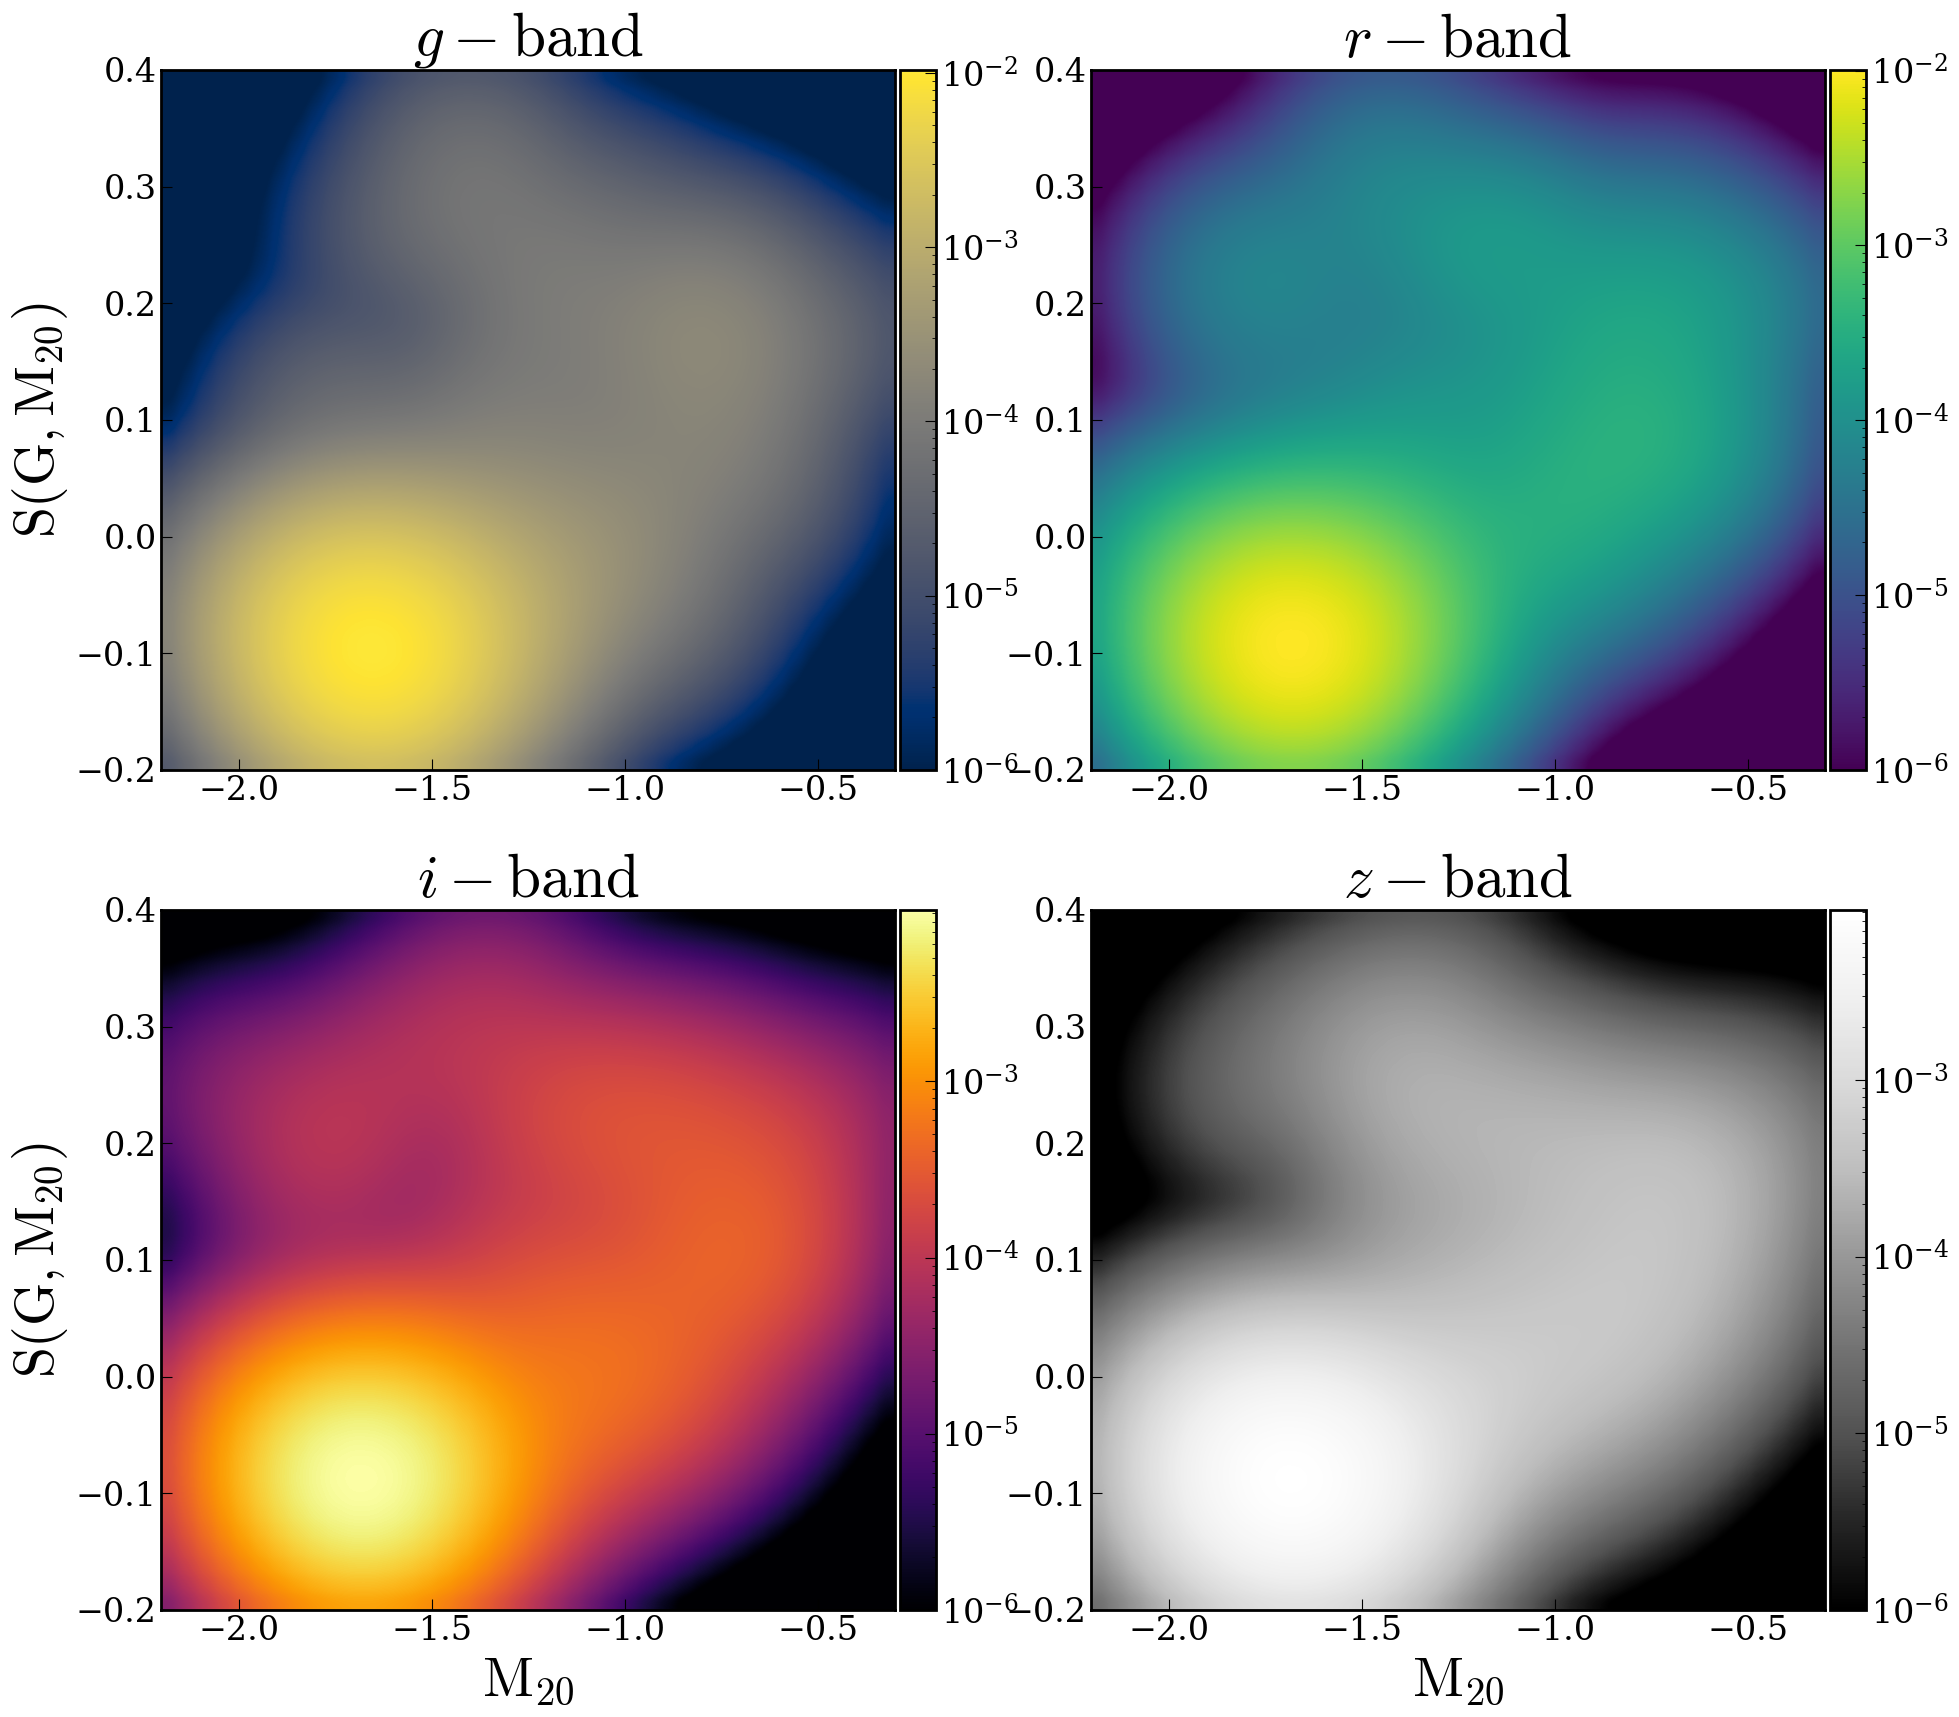

In [128]:
fig,ax=plt.subplots(2,2,figsize=(22,20))

hdx = [-2.2,-0.3,-0.2,0.4]

for i,k in enumerate(channels):

    hss_arr = hess_arr(morph_all[selc,i,2],SGM(morph_all[selc,i,1],morph_all[selc,i,2]), hdx,40)
    im = ax[i//2,i%2].imshow(hss_arr,cmap=channels[k],aspect='auto',extent = hdx,origin='lower',interpolation='gaussian',norm=mcol.LogNorm(vmax=np.amax(hss_arr),vmin=1e-6))



    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    #ax[i//2,i%2].set_ylim((-0.2,0.4))
    #ax[i//2,i%2].set_xlim((-2.2,-0.3))

for j in range(2):
    ax[j,0].set_ylabel( r'$S(G,M_{20})$',fontsize=40)
    ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)



    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=channels[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

In [ ]:
#merger_cand = np.where((morph_all[:,0,1]>merger_line(morph_all[:,0,2]))&(morph_all[:,0,2]>-1.5))[0]
merger_cand = high_snr[np.where((morph_all[high_snr,0,8]<0.3))[0]]

fig1,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)

M20_arr = np.linspace(-2,-0.5,11)
M20_arrhalf = np.linspace(-2,-1.68,11)


for i in range(4):
    mst = sources['logM'].iloc[morph_all[merger_cand,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])


    #ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    #ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].scatter(morph_all[merger_cand,i,8],morph_all[merger_cand,i,1],c=morph_all[merger_cand,i,8],s=120,cmap=filt_cmap[i],vmin=0,vmax=2,edgecolors='black')

    ax1[i].set_ylim((0.3,1.0))
    ax1[i].set_xlim((0,2))
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=40)
    ax1[i].set_rasterized(True)

    plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=filt_cmap[i]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')


ax1[0].set_ylabel( r'${\it Gini}$',fontsize=40)



plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')
'''
fig1,ax1=plt.subplots(1,4,figsize=(24,8),sharey=True)

for i in range(4):
    #merger_cand = np.where(morph_all[:,i,1]>merger_line(morph_all[:,i,2]))[0]

    ax1[i].scatter(morph_all[merger_cand,i,2],morph_all[merger_cand,i,1],alpha=0.5,color=griz_col[i],s=40)

for i in range(4):
    #ax1[i].plot(M20_arr,merger_line(M20_arr),lw=3,ls='--',color='black')
    ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=3,ls='--',color='black')
    
    ax1[i].set_ylim((0.3,1.0))
    ax1[i].set_xlim((-2,-0.5))
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=36)
    ax1[i].set_rasterized(True)

ax1[0].set_ylabel( r'${\it Gini}$',fontsize=36)

plt.subplots_adjust(wspace=0.0)
'''
for k in merger_cand:
        key = sources.iloc[k]
        pos = np.array([key['RA'],key['DEC']])
        try: im = plt.imread('post_cutouts/galseg_{:.4f}_{:.4f}.png'.format(pos[0],pos[1]))
        except: continue

        fig,ax=plt.subplots(figsize=(16,8))
        ax.imshow(im)


In [ ]:

fig,ax=plt.subplots(2,2,figsize=(22,20))

M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)


for i,k in enumerate(channels):

    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    print(k,len(selc))
    
    ax[i//2,i%2].scatter(morph_all[~selc,i,2],SGM(morph_all[~selc,i,1],morph_all[~selc,i,2]),c=morph_all[~selc,i,8],s=80,cmap=channels[k],vmin=0,vmax=2,alpha=0.3)
    im = ax[i//2,i%2].scatter(morph_all[selc,i,2],SGM(morph_all[selc,i,1],morph_all[selc,i,2]),c=morph_all[selc,i,8],s=40,cmap=channels[k],vmin=0,vmax=2,alpha=0.5)


    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    ax[i//2,i%2].set_ylim((-0.2,0.4))
    ax[i//2,i%2].set_xlim((-2.2,-0.3))
    ax[i//2,i%2].set_rasterized(True)

for j in range(2):
    ax[j,0].set_ylabel( r'$S(G,M_{20})$',fontsize=40)
    ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)



    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=channels[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

r 1591
i 1113
z 949


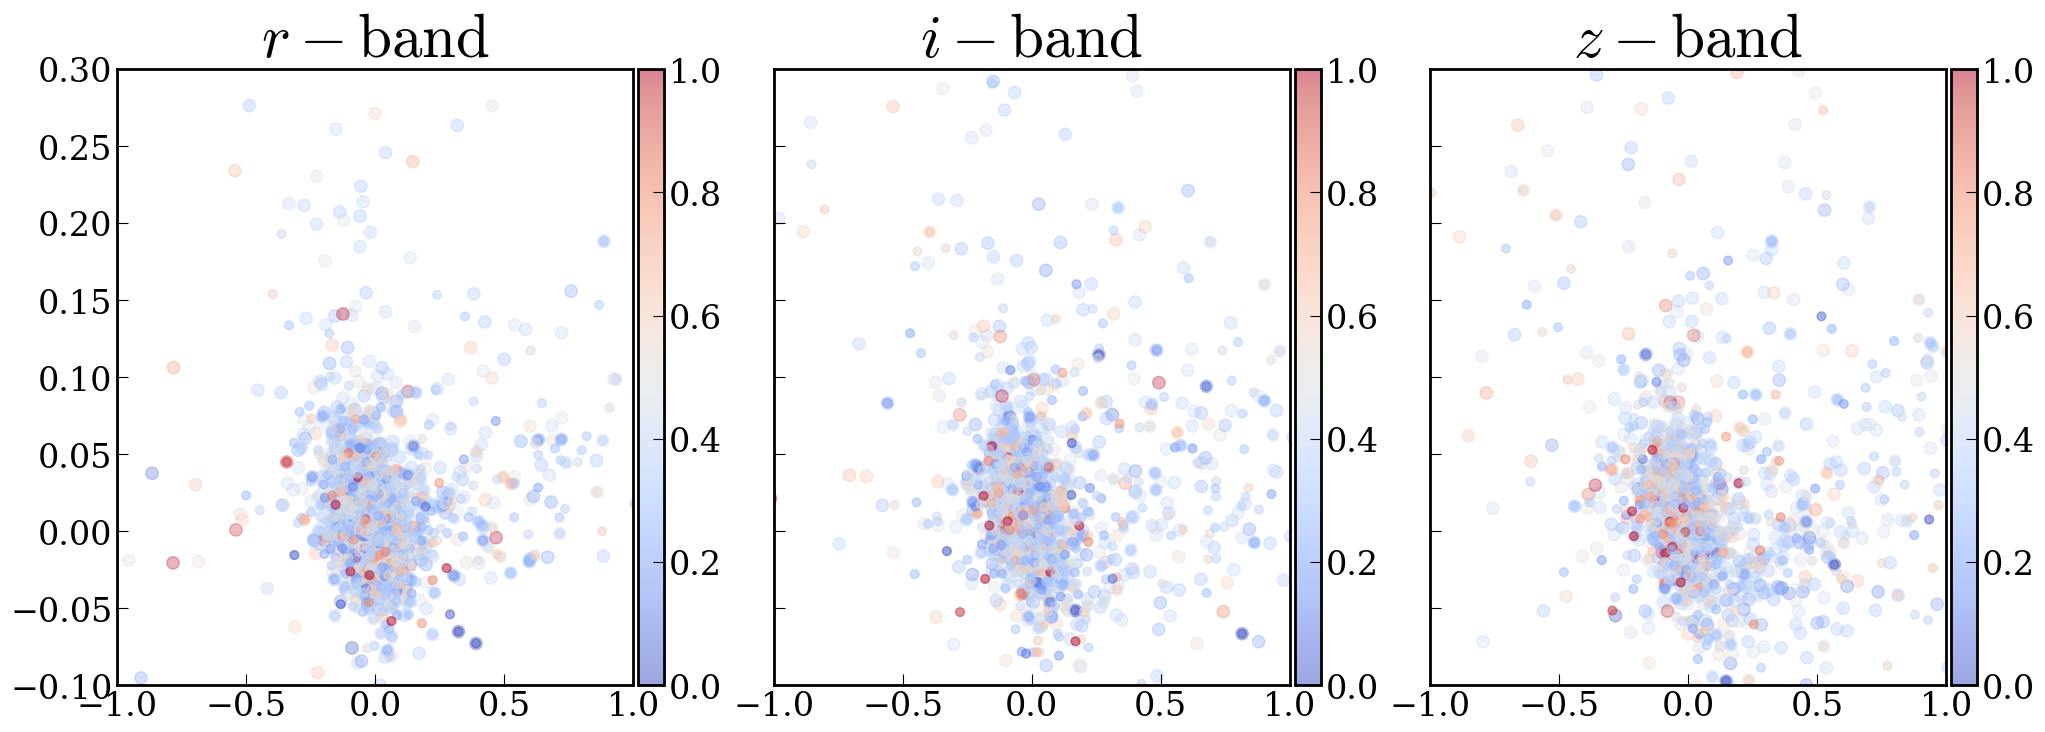

In [115]:
fig,ax=plt.subplots(1,3,figsize=(24,8),sharey='row')

for i,k in enumerate(channels):
    if i>0:
        selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
        print(k,len(selc))
    
        delM = morph_all[:,i,2]-morph_all[:,0,2]
        delG = morph_all[:,i,1]-morph_all[:,0,1]
        g_r = sources['g-r'].iloc[morph_all[selc,0,0]]
        ng_r = sources['g-r'].iloc[morph_all[~selc,0,0]]

        ax[i-1].scatter(delM[~selc],delG[~selc],c=ng_r,s=80,cmap=mcm.coolwarm,vmin=0,vmax=1,alpha=0.3)
        im = ax[i-1].scatter(delM[selc],delG[selc],c=g_r,s=40,cmap=mcm.coolwarm,vmin=0,vmax=1,alpha=0.5)
    
    
        divider = make_axes_locatable(ax[i-1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
        ax[i-1].set_title(r'${\it '+k+'}-band$',fontsize=44)
        ax[i-1].set_ylim((-0.1,0.3))
        ax[i-1].set_xlim((-1,1))
        ax[i-1].set_rasterized(True)


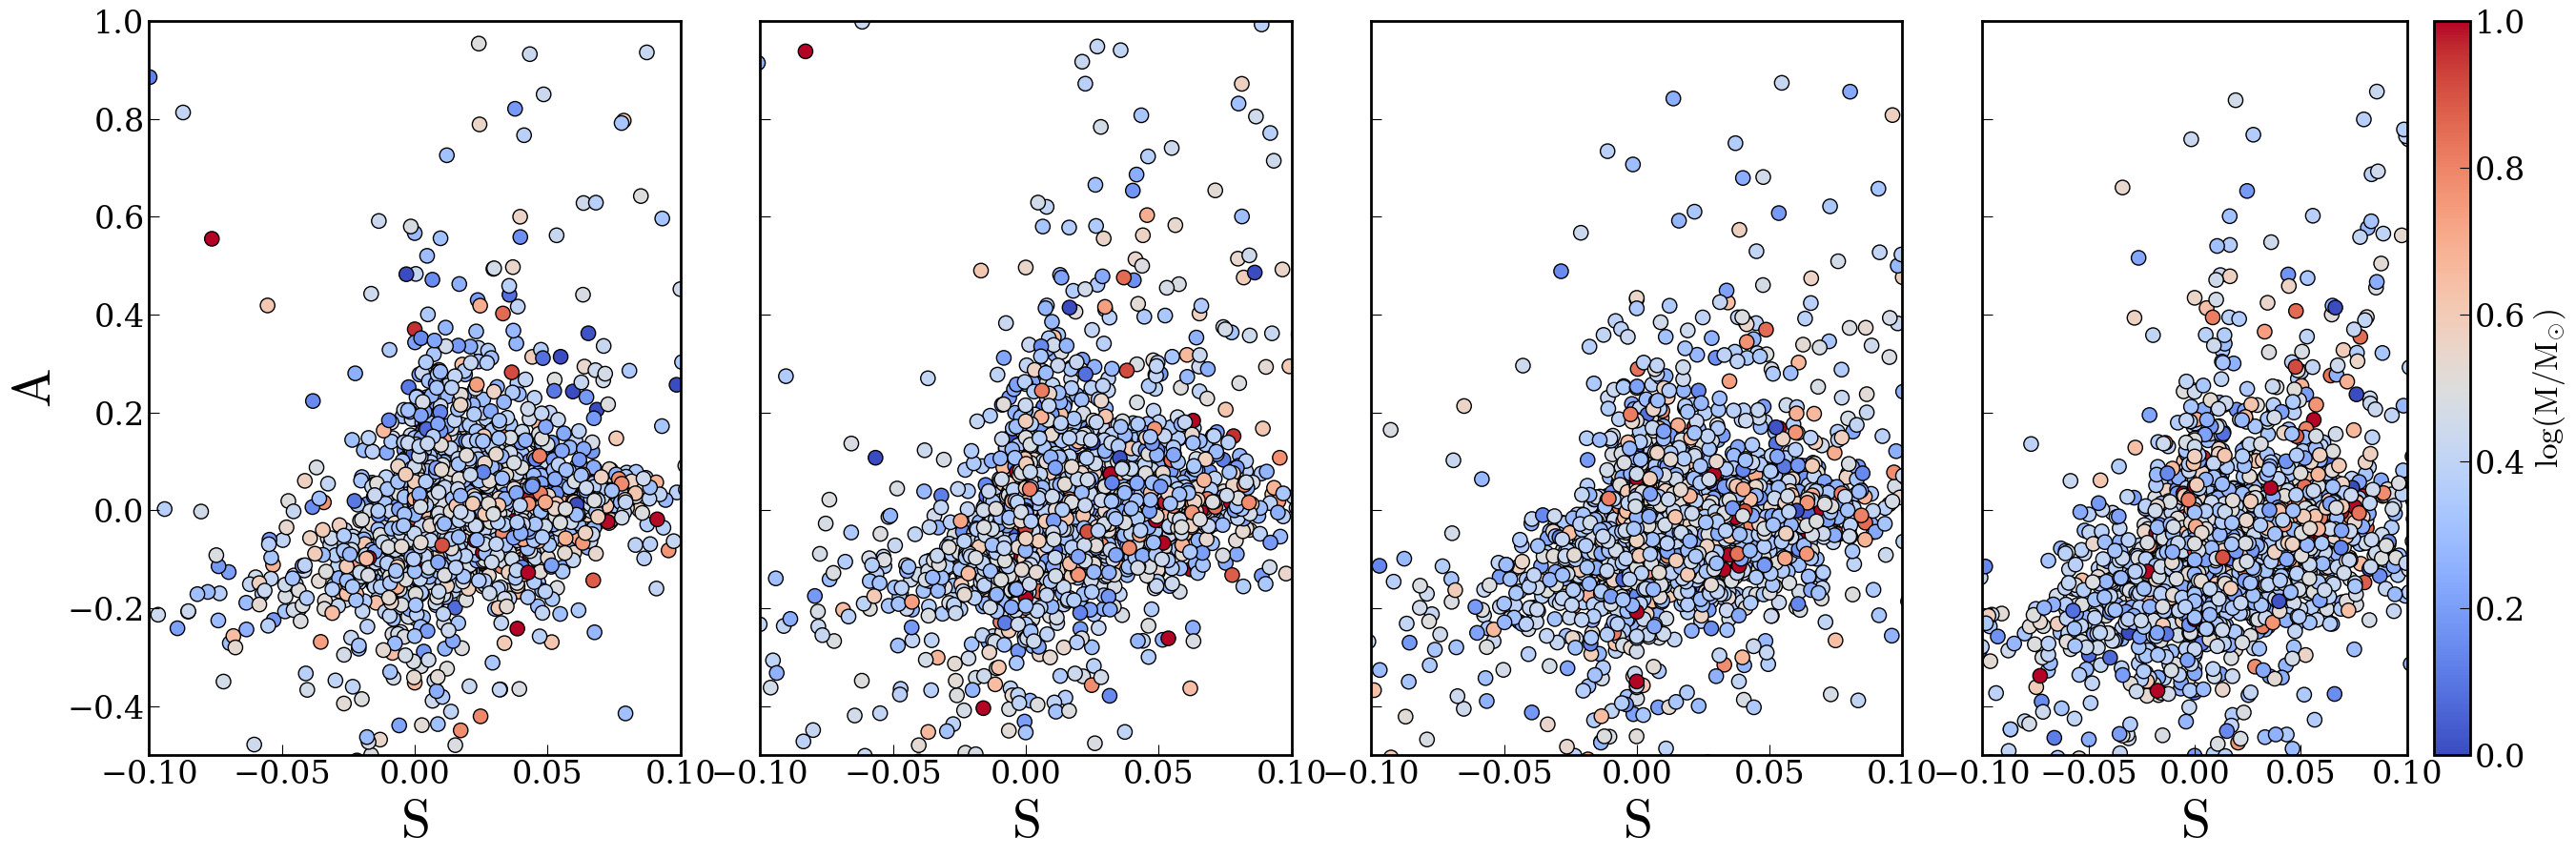

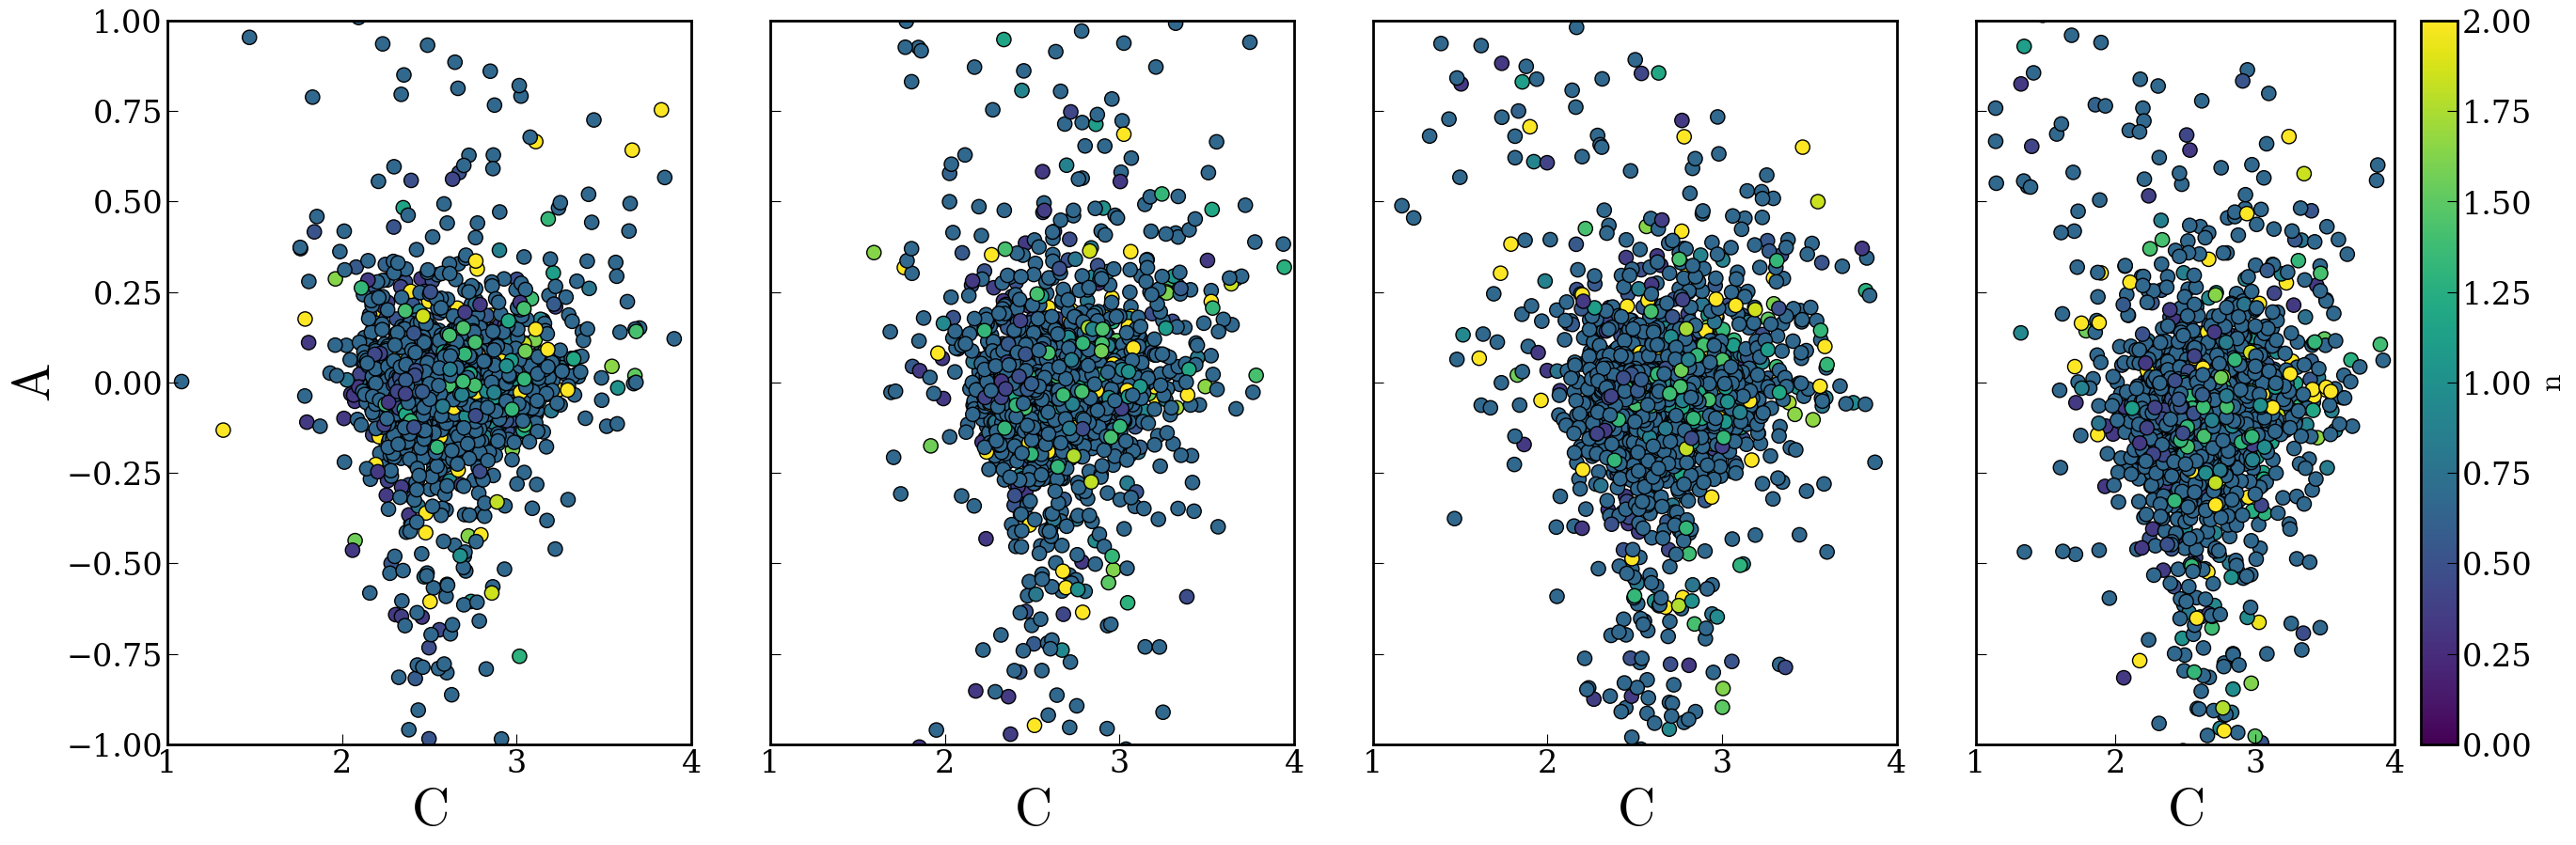

In [39]:
fig,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)


for i in range(4):
    g_r = sources['g-r'].iloc[morph_all[high_snr,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])


    #ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    #ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].scatter(morph_all[high_snr,i,7],morph_all[high_snr,i,6],c=g_r,s=120,cmap=mcm.coolwarm,vmin=0,vmax=1,edgecolors='black')

    ax1[i].set_ylim((-0.5,1))
    ax1[i].set_xlim((-0.1,0.1))
    ax1[i].set_xlabel(r'$S$',fontsize=40)
    ax1[i].set_rasterized(True)

plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=1), cmap=mcm.coolwarm), ax=ax1[3],orientation='vertical',label=r'${\rm log}(M/M_{\odot})$')


ax1[0].set_ylabel( r'$A$',fontsize=40)


plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

fig,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)


for i in range(4):
    g_r = sources['SERSIC'].iloc[morph_all[high_snr,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])


    #ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    #ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].scatter(morph_all[high_snr,i,5],morph_all[high_snr,i,6],c=g_r,s=120,cmap=mcm.viridis,vmin=0,vmax=3,edgecolors='black')

    ax1[i].set_ylim((-1,1))
    ax1[i].set_xlim((1,4))
    ax1[i].set_xlabel(r'$C$',fontsize=40)
    ax1[i].set_rasterized(True)

plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=mcm.viridis), ax=ax1[3],orientation='vertical',label=r'$n$')


ax1[0].set_ylabel( r'$A$',fontsize=40)


plt.subplots_adjust(wspace=0.15)


ValueError: x and y must have same first dimension, but have shapes (4,) and (1052,)

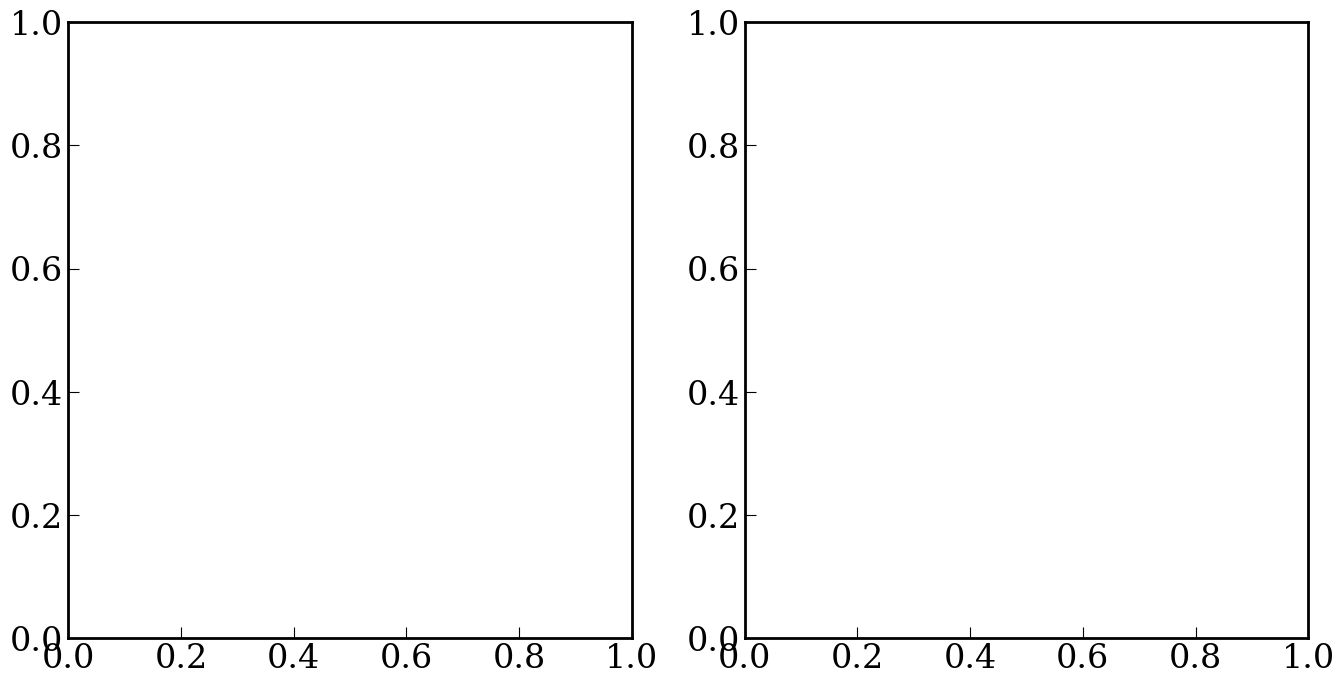

In [49]:
fig1,ax1=plt.subplots(1,2,figsize=(16,8))


for i in range(4):
    zsp = sources['zspec'].iloc[morph_all[high_snr,i,0]]

    ax1[0].plot(filt_arr,morph_all[high_snr,i,1],alpha=0.5,c=zsp,cmap=mcm.inferno,vmin=0,vmax=0.1)
    ax1[1].plot(filt_arr,morph_all[high_snr,i,2],alpha=0.5,c=zsp,cmap=mcm.inferno,vmin=0,vmax=0.1)
'''
    ax1[i].set_ylim((0.3,1.0))
    ax1[i].set_xlim((-2,-0.5))
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=36)
    ax1[i].set_rasterized(True)
'''
ax1[0].set_ylabel( r'${\it Gini}$',fontsize=36)